In [ ]:
### !pip install tensorflow matplotlib

from tensorflow.keras import layers, Sequential, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os
import matplotlib.pyplot as plt
import random
import numpy as np

2024-04-08 23:54:33.453344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 23:54:33.453445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 23:54:33.569330: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Part 1: Importing necessary libraries and datasets

In [ ]:
!pip install kaggle
!kaggle datasets download -d catherinemcconnell/cifar-100-python
!unzip cifar-100-python.zip

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.10/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open cifar-100-python.zip, cifar-100-python.zip.zip or cifar-100-python.zip.ZIP.


Step 2: Data Preprocessing

Display example images from CIFAR-100 Dataset

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Shape of train_images: (50000, 32, 32, 3)
Shape of train_labels: (50000, 1)


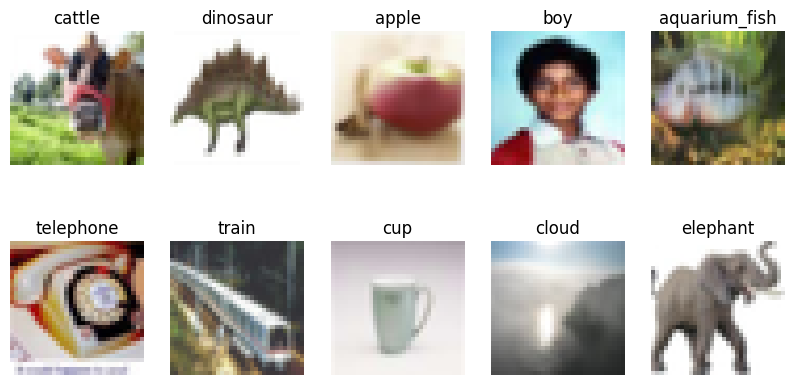

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar100

# Load CIFAR-100 dataset
(train_images, train_labels), (_, _) = cifar100.load_data()

# Print the shapes of train_images and train_labels
print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)

# Map class labels to class names
class_names = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

# Display 5 images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis('off')
plt.show()


# Step 3: Define and Train the Model

#### The model is trained using the pretrained EfficientNet-B0 base model.
#### To increase the accuracy of the model we add
#### L2 Regularization and Batch Normalization using VGG-Style Layers.

#### To reduce overfitting and improve generalization performance, we add a 'GlobalAveragePoolingLayer'.

#### Early Stopping is implemented to stop the model from training too long without improvement, and to save the weights from the model's best epoch.

#### A a data augmentation generator is also used to reduce overfitting.

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Load the CIFAR-100 dataset
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Load the EfficientNet-B0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Create a new model
model = models.Sequential()

# Add the EfficientNet-B0 base model
model.add(base_model)

# Add VGG-style layers with L2 regularization and BatchNormalization
l2_lambda = 0.001  # Adjust the regularization strength as needed
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))  # Add dropout after convolutional layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))  # Add dropout after convolutional layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))  # Add dropout after convolutional layer
model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))  # Add dropout after convolutional layer
model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Add GlobalAveragePooling2D layer
model.add(layers.GlobalAveragePooling2D())

# Add Dense layers with L2 regularization
model.add(layers.Dense(1024, activation='relu', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))
model.add(layers.Dropout(0.5))  # Add dropout after dense layer
model.add(layers.Dense(100, activation='softmax', kernel_initializer=glorot_uniform(seed=0), kernel_regularizer=l2(l2_lambda)))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=20, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

# Define a data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model with data augmentation and dropout
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64),
    epochs=100,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/782 ━━━━━━━━━━━━━━━━━━━━ 22:39:50 104s/step - accuracy: 0.0000e+00 - loss: 8.6958

I0000 00:00:1712620675.955321     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 219s 146ms/step - accuracy: 0.0302 - loss: 6.0530 - val_accuracy: 0.0734 - val_loss: 4.8276
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.1073 - loss: 4.3352 - val_accuracy: 0.1805 - val_loss: 3.6867
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.1624 - loss: 3.7592 - val_accuracy: 0.1696 - val_loss: 3.6980
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.1781 - loss: 3.5955 - val_accuracy: 0.2152 - val_loss: 3.3872
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.1881 - loss: 3.5481 - val_accuracy: 0.1839 - val_loss: 3.8943
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 50ms/step - accuracy: 0.1912 - loss: 3.5453 - val_accuracy: 0.2565 - val_loss: 3.2713
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - accuracy: 0.2136 - loss: 3.4265 - val_accuracy: 0.2621 - val_loss: 3.2435
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.2335 - loss: 3.3117 - va

# Evaluate the model by making predictions on unseen data.

### Random images are also selected to increase model credibility.


Here we use numbers instead of class names

313/313 - 2s - 8ms/step - accuracy: 0.5656 - loss: 2.1372

Test accuracy: 0.5655999779701233
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


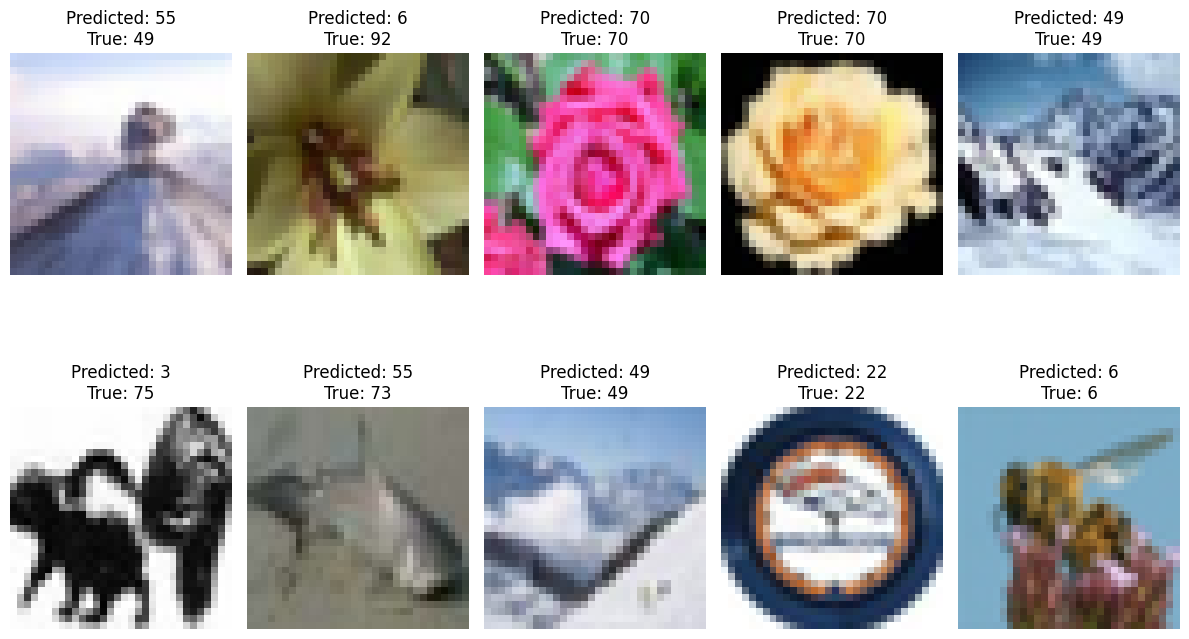

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Function to display images with their predicted and true labels
def display_images(images, predicted_labels, true_labels, class_names, num_images=10):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {predicted_labels[i]}\nTrue: {class_names[true_labels[i][0]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load and preprocess validation images (use the actual validation data)
validation_images = test_images
validation_labels = test_labels

# Make predictions on the validation data
predictions = model.predict(validation_images)

# Convert predictions to class labels
predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]

# Get unique predicted classes
unique_predicted_classes = set(predicted_labels)

# Select 10 random classes from the unique predicted classes
np.random.seed(42)  # For reproducibility
random_classes = np.random.choice(list(unique_predicted_classes), size=10, replace=True)

# Filter predictions and true labels for selected random classes
selected_indices = [i for i, label in enumerate(predicted_labels) if label in random_classes]
selected_predicted_labels = [predicted_labels[i] for i in selected_indices]
selected_true_labels = [validation_labels[i] for i in selected_indices]
selected_images = [validation_images[i] for i in selected_indices]

# Display only 10 images with their predicted and true labels for selected random classes
display_images(selected_images, selected_predicted_labels, selected_true_labels, class_names, num_images=10)

Here we use the class names of the images

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


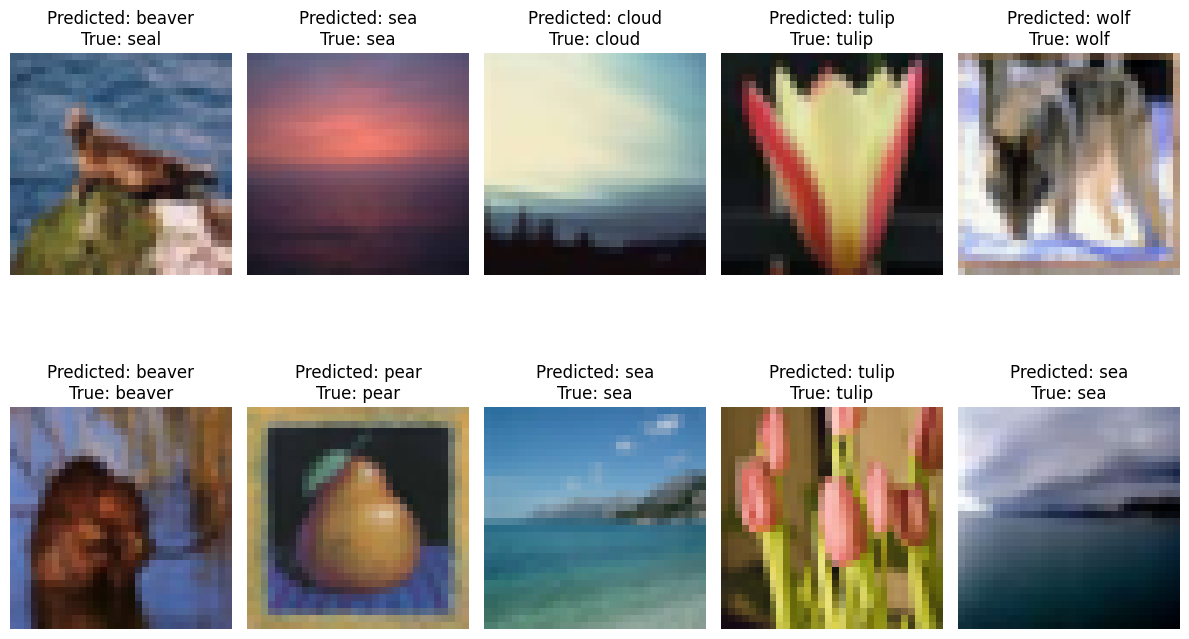

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Function to display images with their predicted and true labels
def display_images(images, predicted_labels, true_labels, class_names, num_images=10):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Predicted: {predicted_labels[i]}\nTrue: {class_names[true_labels[i][0]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Load and preprocess validation images (use the actual validation data)
validation_images = test_images
validation_labels = test_labels

# Make predictions on the validation data
predictions = model.predict(validation_images)

# Convert predictions to class labels
class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
               'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
               'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
               'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house',
               'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man',
               'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid',
               'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
               'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew',
               'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
               'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
               'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

predicted_labels = [class_names[np.argmax(pred)] for pred in predictions]

# Get unique predicted classes
unique_predicted_classes = set(predicted_labels)

# Select 10 random classes from the unique predicted classes
np.random.seed(42)  # For reproducibility
random_classes = np.random.choice(list(unique_predicted_classes), size=10, replace=False)

# Filter predictions and true labels for selected random classes
selected_indices = [i for i, label in enumerate(predicted_labels) if label in random_classes]
selected_predicted_labels = [predicted_labels[i] for i in selected_indices]
selected_true_labels = [validation_labels[i] for i in selected_indices]
selected_images = [validation_images[i] for i in selected_indices]

# Display only 10 images with their predicted and true labels for selected random classes
display_images(selected_images, selected_predicted_labels, selected_true_labels, class_names, num_images=10)




### Using precision, F-1 Score, and Recall and other evaluation metrics implemented to truly understand the model's performance

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

# Load and preprocess validation images (use the actual validation data)
validation_images = test_images
validation_labels = test_labels

# Make predictions on the validation data
predictions = model.predict(validation_images)

# Convert predictions to class labels
predicted_labels = [np.argmax(pred) for pred in predictions]

# Compute additional evaluation metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')
f1 = f1_score(test_labels, predicted_labels, average='macro')

# Print the additional evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Generate classification report
class_names = [str(i) for i in range(100)]  # Assuming you have 100 classes
report = classification_report(test_labels, predicted_labels, target_names=class_names)
print('Classification Report:')
print(report)



313/313 - 2s - 8ms/step - accuracy: 0.5656 - loss: 2.1372

Test accuracy: 0.5655999779701233
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.5656
Precision: 0.5937698576099862
Recall: 0.5656
F1 Score: 0.5667427534699292
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       100
           1       0.77      0.69      0.73       100
           2       0.65      0.32      0.43       100
           3       0.23      0.44      0.31       100
           4       0.28      0.47      0.35       100
           5       0.83      0.49      0.62       100
           6       0.44      0.81      0.57       100
           7       0.77      0.55      0.64       100
           8       0.80      0.74      0.77       100
           9       0.89      0.68      0.77       100
          10       0.39      0.33      0.36       100
          11       0.28      0.34      0.31       100
          12       0.73      0.69      0.71      